<a href="https://colab.research.google.com/github/MathewBiddle/notebooks_demos/blob/GTS_widgets/notebooks/2020-10-10-GTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IOOS GTS Statistics


The Global Telecommunication System (GTS) is a coordinated effort for rapid distribution of observations.
The GTS monthly reports show the number of messages released to GTS for each station.
The reports contain the following fields:

- location ID: Identifier that station messages are released under to the GTS;
- region: Designated IOOS Regional Association (only for IOOS regional report);
- sponsor: Organization that owns and maintains the station;
- Met: Total number of met messages released to the GTS
- Wave: Total number of wave messages released to the GTS

In this notebook we will explore the statistics of the messages IOOS is releasing to GTS.

The first step is to pick the appropriate date range of interest.

In [1]:
from datetime import date,timedelta
import ipywidgets as widgets

start_date = widgets.DatePicker(
    description='Start Date',
    disabled=False
)

end_date = widgets.DatePicker(
    description='End Date',
    disabled=False
)

display(start_date)
display(end_date)

DatePicker(value=None, description='Start Date')

DatePicker(value=None, description='End Date')

Now we download the data. We will use an ERDDAP server that [hosts the CSV files](https://ferret.pmel.noaa.gov/generic/erddap/files/ioos_obs_counts/) with the ingest data.

In [2]:
import pandas as pd
# example https://www.ndbc.noaa.gov/ioosstats/rpts/2021_03_ioos_regional.csv

start = start_date.get_interact_value()
end = end_date.get_interact_value()

# build an array for days between dates
date_array = (start + timedelta(days=x) for x in range(0, (end-start).days))

# get a unique list of year-months for url build
months=[]
for date_object in date_array:
    months.append(date_object.strftime("%Y-%m"))
months = sorted(set(months))

df = pd.DataFrame(columns=['locationID', 'region', 'sponsor', 'met', 'wave'])
for month in months:
  url = 'https://www.ndbc.noaa.gov/ioosstats/rpts/%s_ioos_regional.csv' % month.replace("-","_")
  print('Downloading %s' % url)
  df1 = pd.read_csv(url)
  df1['time (UTC)'] = pd.to_datetime(month)
  df = pd.concat([df,df1])

df

,locationID,region,sponsor,met,wave,time (UTC)
0,46108,AOOS,ALASKA OCEAN OBSERVING SYSTEM,0,2962,2021-01-01
1,HAXA2,AOOS,MARINE EXCHANGE OF ALASKA,8774,0,2021-01-01
2,JMLA2,AOOS,MARINE EXCHANGE OF ALASKA,8772,0,2021-01-01
3,NKLA2,AOOS,MARINE EXCHANGE OF ALASKA,8614,0,2021-01-01
4,GIXA2,AOOS,MARINE EXCHANGE OF ALASKA,8782,0,2021-01-01
...,...,...,...,...,...,...
149,SSBN7,SECOORA,COASTAL OCEAN RESEARCH AND MONITORING PROGRAM,0,1810,2021-03-01
150,41159,SECOORA,COASTAL OCEAN RESEARCH AND MONITORING PROGRAM,0,1570,2021-03-01
151,SIPF1,SECOORA,FLORIDA INSTITUTE OF TECHNOLOGY,3802,0,2021-03-01
152,42098,SECOORA,GREATER TAMPA BAY MARINE ADVISORY COUNCIL PORTS,0,1920,2021-03-01


In [3]:
#df = e.to_pandas(parse_dates=True)

df["locationID"] = df["locationID"].str.lower()

df['time (UTC)'].unique()

array(['2021-01-01T00:00:00.000000000', '2021-02-01T00:00:00.000000000',
       '2021-03-01T00:00:00.000000000'], dtype='datetime64[ns]')

The table has all the ingest data. We can now explore it grouping the data by IOOS Regional Association (RA).

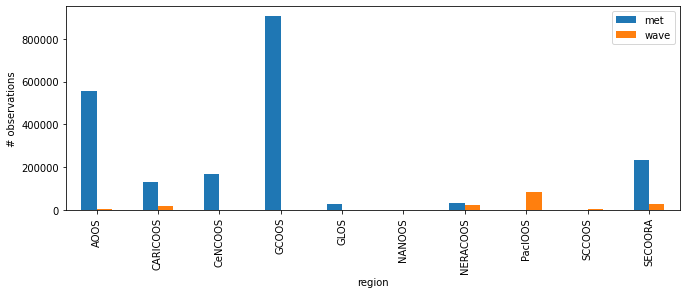

In [4]:
groups = df.groupby("region")

ax = groups.sum().plot(kind="bar", figsize=(11, 3.75))
ax.yaxis.get_major_formatter().set_scientific(False)
ax.set_ylabel("# observations");

Let us check the montly sum of data released both for individual met and wave and the totals.

In [5]:
import pandas as pd

df["time (UTC)"] = pd.to_datetime(df["time (UTC)"])
# Remove time-zone info for easier plotting, it is all UTC.
df["time (UTC)"] = df["time (UTC)"].dt.tz_localize(None)

groups = df.groupby(pd.Grouper(key="time (UTC)", freq="M"))

We can create a table of observations per month,

In [6]:
s = groups[['time (UTC)','met','wave']].sum() # reducing the columns so the summary is digestable
totals = s.assign(total=s["met"] + s["wave"])
totals.index = totals.index.to_period("M")

print('Monthly totals:\n',totals,'\n')

print('Sum for time period %s to %s: %i'%(totals.index.min(),totals.index.max(),totals['total'].sum()))

Monthly totals:
                met   wave   total
time (UTC)                       
2021-01     819092  70784  889876
2021-02     712442  61024  773466
2021-03     530520  44916  575436 

Sum for time period 2021-01 to 2021-03: 2238778


and visualize it in a bar plot.

Text(0, 0.5, '# observations')

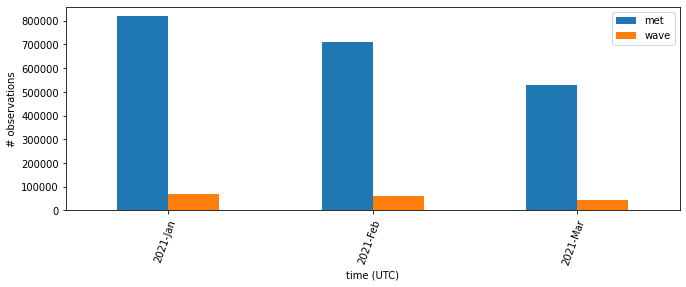

In [7]:
%matplotlib inline
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(11, 3.75))

s.plot(ax=ax, kind="bar")
ax.set_xticklabels(
    labels=s.index.to_series().dt.strftime("%Y-%b"),
    rotation=70,
    rotation_mode="anchor",
    ha="right",
)
ax.yaxis.get_major_formatter().set_scientific(False)
ax.set_ylabel("# observations")

Those plots are intersting to understand the RAs role in the GTS ingest and how much data is being released over time. It would be nice to see those per buoy on a map.

For that we need to get the position of the NDBC buoys. Let's get a table of all the buoys and match with what we have in teh GTS data.

In [8]:
import xml.etree.ElementTree as et

import pandas as pd
import requests


def make_ndbc_table():
    url = "https://www.ndbc.noaa.gov/activestations.xml"
    with requests.get(url) as r:
        elems = et.fromstring(r.content)
    df = pd.DataFrame([elem.attrib for elem in list(elems)])
    df["id"] = df["id"].str.lower()
    return df.set_index("id")


buoys = make_ndbc_table()
buoys["lon"] = buoys["lon"].astype(float)
buoys["lat"] = buoys["lat"].astype(float)

buoys.head()

,lat,lon,name,owner,pgm,type,met,currents,waterquality,dart,elev,seq
id,,,,,,,,,,,,
00922,30.0,-90.0,OTN201 - 4800922,Dalhousie University,IOOS Partners,other,n,n,n,n,NaN,NaN
00923,30.0,-90.0,OTN200 - 4800923,Dalhousie University,IOOS Partners,other,n,n,n,n,NaN,NaN
01500,30.0,-90.0,SP031 - 3801500,SCRIPPS,IOOS Partners,other,n,n,n,n,NaN,NaN
01502,30.0,-90.0,Penobscot - 4801502,University of Maine,IOOS Partners,other,n,n,n,n,NaN,NaN
01503,30.0,-90.0,Saul - 4801503,Woods Hole Oceanographic Institution,IOOS Partners,other,n,n,n,n,NaN,NaN


For simplificty we will plot the total of observations per buoys.

In [9]:
groups = df.groupby("locationID")
location_sum = groups.sum()

In [10]:
buoys = buoys.T

extra_cols = pd.DataFrame({k: buoys.get(k) for k, row in location_sum.iterrows()}).T
extra_cols = extra_cols[["lat", "lon", "type", "pgm", "name"]]

map_df = pd.concat([location_sum, extra_cols], axis=1)
map_df = map_df.loc[map_df["met"] + map_df["wave"] > 0]

And now we can overlay an HTML table with the buoy information and ingest data totals.

In [11]:
from ipyleaflet import AwesomeIcon, Marker, Map, LegendControl, FullScreenControl, Popup
from ipywidgets import HTML


m = Map(center=(35, -95), zoom=4)
m.add_control(FullScreenControl())

legend = LegendControl(
    {
        "wave": "#FF0000",
        "met": "#FFA500",
        "both": "#008000"
    },
    name="GTS",
    position="bottomright",
)
m.add_control(legend)


def make_popup(row):
    classes = "table table-striped table-hover table-condensed table-responsive"
    return pd.DataFrame(row[["met", "wave", "type", "name", "pgm"]]).to_html(
        classes=classes
    )

for k, row in map_df.iterrows():
    if (row["met"] + row["wave"]) > 0:
        location = row["lat"], row["lon"]
        if row["met"] == 0:
            color = "red"
        elif row["wave"] == 0:
            color = "orange"
        else:
            color = "green"
        marker = Marker(
            draggable=False,
            icon=AwesomeIcon(name="life-ring", marker_color=color),
            location=location,
        )
        msg = HTML()
        msg.value = make_popup(row)
        marker.popup = msg
        m.add_layer(marker)
m

Map(center=[35, -95], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…